## Reload the `EC_estimator.py` code to consider any changes

In [1]:
#reload model magic
%load_ext autoreload
%autoreload 2

import EC_estimator as annec

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate
import EC_estimator as annec
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model

In [118]:
tf.__version__

'2.2.0'

## Load the dataset, preprocessing, and apply ANN model

In [ ]:
import numpy as np
import pandas as pd

import EC_estimator as annec
import tensorflow as tf

# ------------------------------------------------------------
# Settings
# ------------------------------------------------------------
predictors = ["dcc", "exports", "sac", "sjr", "tide", "net_dcd", "smscg"]
target = "EC"
WINDOW = 118  # 1 + 7 + (10*11)

test_start  = "1923-01-01"
test_end    = "1939-12-31"
train_start = "1940-01-01"
train_end   = "2015-12-31"


# ------------------------------------------------------------
# Helper: create sliding windows
# ------------------------------------------------------------
def make_windows(df_raw: pd.DataFrame, predictors, target, window: int):
    """
    Builds:
      X_seq: (N, window, n_predictors)
      y:     (N, 1)

    Backward alignment:
      window rows are [t-window+1, ..., t]  (history ending at t)
      y is df_raw[target].iloc[t]
    """
    X_all = df_raw[predictors].to_numpy()
    y_all = df_raw[target].to_numpy().reshape(-1, 1)

    if len(df_raw) < window:
        raise ValueError(f"Not enough rows ({len(df_raw)}) to build a window of {window}.")

    Xw = []
    yw = []

    # t is the "current day" index
    for t in range(window - 1, len(df_raw)):
        Xw.append(X_all[t - window + 1 : t + 1, :])  # (window, n_predictors), ends at t
        yw.append(y_all[t])                          # target at t

    X_seq = np.stack(Xw, axis=0)
    y = np.vstack(yw)
    return X_seq, y



# ------------------------------------------------------------
# Load raw daily data (date + 7 predictors + EC)
# ------------------------------------------------------------
df = annec.load_data("Inputs/EC_inputs.csv")

df["date"] = pd.to_datetime(df["date"], errors="raise")
df = df.sort_values("date")

# Keep date for splitting; do NOT convert to MultiIndex lags
df = df.reset_index(drop=True)

# Sanity check columns
missing_cols = [c for c in (["date"] + predictors + [target]) if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns in EC_inputs.csv: {missing_cols}")


# ------------------------------------------------------------
# Split by date ranges on raw data
# ------------------------------------------------------------
df_test_raw  = df[(df["date"] >= test_start) & (df["date"] <= test_end)].copy()
df_train_raw = df[(df["date"] >= train_start) & (df["date"] <= train_end)].copy()

if df_test_raw.empty:
    raise ValueError("df_test_raw is empty. Check that dates exist in 1923–1939.")
if df_train_raw.empty:
    raise ValueError("df_train_raw is empty. Check that dates exist in 1940–2015.")

print("Train:", df_train_raw["date"].min().date(), "→", df_train_raw["date"].max().date(), "rows:", len(df_train_raw))
print("Test :", df_test_raw["date"].min().date(),  "→", df_test_raw["date"].max().date(),  "rows:", len(df_test_raw))


# ------------------------------------------------------------
# Build raw windows (118 days × 7 predictors)
# ------------------------------------------------------------
X_train_seq, y_train_arr = make_windows(df_train_raw, predictors, target, WINDOW)
X_test_seq,  y_test_arr  = make_windows(df_test_raw,  predictors, target, WINDOW)

# Convert to "7 inputs" format: each is (N,118)
X_train = [X_train_seq[:, :, i] for i in range(len(predictors))]
X_test  = [X_test_seq[:, :, i]  for i in range(len(predictors))]

# Targets as DataFrame
y_train = pd.DataFrame(y_train_arr, columns=[target])
y_test  = pd.DataFrame(y_test_arr,  columns=[target])

print("\nX_train shapes:", [x.shape for x in X_train])  # expect 7 × (N,118)
print("y_train shape :", y_train.shape)
print(f"y_train range (original): [{y_train.values.min():.1f}, {y_train.values.max():.1f}]")
print(f"y_test range (original) : [{y_test.values.min():.1f}, {y_test.values.max():.1f}]")


# ------------------------------------------------------------
# Build model
# Model outputs predictions in SCALED space [0.1, 0.9]
# For inference in original units, use create_inference_model()
# ------------------------------------------------------------
inputs = annec.build_model_inputs(None)

# Preprocessing layers: antecedent extraction + z-score normalization (embedded in model)
layers = annec.preprocessing_layers(df_train_raw, inputs, X_train)

print(f"\nBuilt {len(layers)} input preprocessing layers")

# Build model - stores scaling parameters but doesn't use them during training
model, tensorboard_cb = annec.build_model(layers, inputs, y_train=y_train)

print("\nModel summary:")
model.summary()

# Scale targets to [0.1, 0.9] for training
y_train_scaler = annec.MinMaxScaleLayer(feature_range=(0.1, 0.9), name="temp_y_scale")
y_train_scaler.adapt(y_train.values)
y_train_scaled = y_train_scaler(tf.constant(y_train.values, dtype=tf.float32)).numpy()

y_test_scaler = annec.MinMaxScaleLayer(feature_range=(0.1, 0.9), name="temp_y_scale_test")
y_test_scaler.adapt(y_train.values)  # Use TRAIN range for test scaling
y_test_scaled = y_test_scaler(tf.constant(y_test.values, dtype=tf.float32)).numpy()

print(f"\nScaled y_train range: [{y_train_scaled.min():.4f}, {y_train_scaled.max():.4f}]")
print(f"Scaled y_test range : [{y_test_scaled.min():.4f}, {y_test_scaled.max():.4f}]")


# ------------------------------------------------------------
# Train model
# Model learns to output directly in scaled space [0.1, 0.9]
# ------------------------------------------------------------
history, model = annec.train_model(
    model, tensorboard_cb, 
    X_train, y_train_scaled,    # Scaled targets [0.1, 0.9]
    X_test, y_test_scaled,      # Scaled validation [0.1, 0.9]
    epochs=1000,
    patience=1000,
    batch_size=128
)

Train: 1940-01-01 → 2015-09-29 rows: 27666
Test : 1923-04-28 → 1939-12-31 rows: 6092

X_train shapes: [(27549, 118), (27549, 118), (27549, 118), (27549, 118), (27549, 118), (27549, 118), (27549, 118)]
y_train shape : (27549, 1)
y_train range (original): [171.2, 5803.9]
y_test range (original) : [175.0, 5653.3]

Built 7 input preprocessing layers

Model summary:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sac_input (InputLayer)          [(None, 118)]        0                                            
__________________________________________________________________________________________________
exports_input (InputLayer)      [(None, 118)]        0                                            
__________________________________________________________________________________________________
dcc_input (InputLayer)     

## Evaluation of the model

In [4]:
# Calculate metrics for ANN
# The trained model outputs scaled predictions [0.1, 0.9]
# We create an inference model that automatically inverse-transforms to original units

metrics = []

# Predict with trained model (outputs are scaled [0.1, 0.9])
y_train_pred_scaled = model.predict(X_train, verbose=0)
y_test_pred_scaled  = model.predict(X_test, verbose=0)

# Create inference model with automatic inverse scaling
inference_model = annec.create_inference_model(model)

# Predict with inference model (outputs are original units)
y_train_pred = inference_model.predict(X_train, verbose=0)
y_test_pred  = inference_model.predict(X_test, verbose=0)

print("=== Predictions (original EC units, last 3 samples) ===")
print("train:", y_train_pred[-3:].ravel())
print("test :", y_test_pred[-3:].ravel())

print("\n=== Scaled predictions range ===")
print(f"y_train_pred_scaled: [{y_train_pred_scaled.min():.4f}, {y_train_pred_scaled.max():.4f}]")
print(f"y_test_pred_scaled:  [{y_test_pred_scaled.min():.4f}, {y_test_pred_scaled.max():.4f}]")

print("\n=== Original unit predictions range ===")
print(f"y_train_pred: [{y_train_pred.min():.1f}, {y_train_pred.max():.1f}]")
print(f"y_test_pred : [{y_test_pred.min():.1f}, {y_test_pred.max():.1f}]")

# Compute metrics using original (unscaled) values
y_train_true = y_train.values  # Original EC values
y_test_true  = y_test.values   # Original EC values

metrics.append(
    annec.calculate_metrics("ANN", y_train, y_train_pred, y_test, y_test_pred)
)

df3 = pd.DataFrame(metrics)
print("\n=== Model Performance ===")
print(df3)

=== Predictions (original EC units, last 3 samples) ===
train: [3699.4558 3935.8977 4192.7793]
test : [1168.4774 1042.6683  902.8076]

=== Scaled predictions range ===
y_train_pred_scaled: [0.1000, 0.8455]
y_test_pred_scaled:  [0.1016, 0.7807]

=== Original unit predictions range ===
y_train_pred: [171.2, 5420.3]
y_test_pred : [182.6, 4963.6]

=== Model Performance ===
  Model  Train_R2  Train_RMSE  Train_Percentage_Bias  Test_R2  Test_RMSE  \
0   ANN     0.986      104.12                   3.08    0.965     205.77   

   Test_Percentage_Bias  
0                  3.18  


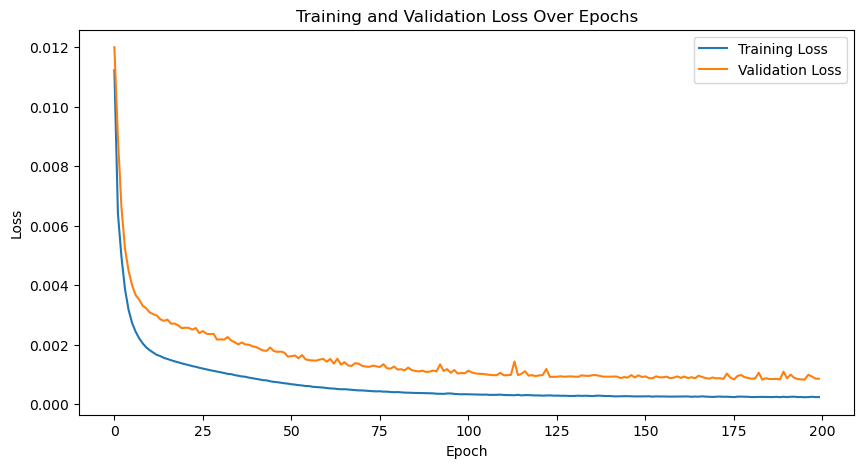

In [5]:
annec.plot_history(history)

## Plot the ANN prediction versus the test target as a time series

Last prediction: 981.3


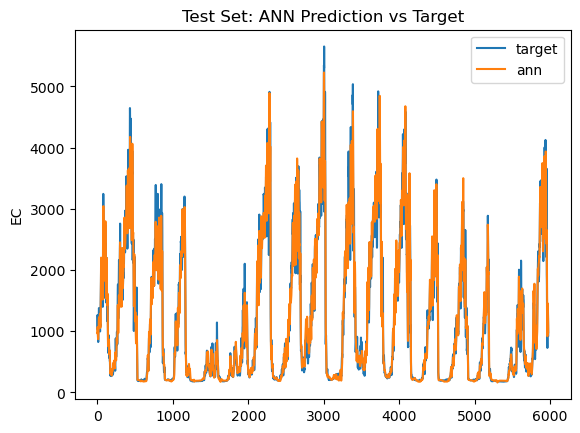

In [29]:
# Plot predictions vs actual (in original EC units)
import matplotlib.pyplot as plt

ax = y_test.plot(label='target')
pred = pd.DataFrame(index=y_test.index, data=y_test_pred, columns=['prediction'])
print(f"Last prediction: {pred.iloc[-1].values[0]:.1f}")
pred.plot(ax=ax)
plt.ylabel('EC')
plt.legend(["target", "ann"])
plt.title('Test Set: ANN Prediction vs Target')
plt.show()

## Save the final model

In [ ]:
############################################################################################
############# Please change the model_save_path to the direction you saved the files #######
############################################################################################

model_save_path = r'./Export/emmaton'
annec.save_model(model, model_save_path)

# Also save the inference model (with inverse scaling built-in)
inference_model_path = os.path.join(model_save_path, 'inference_model')
inference_model.save(inference_model_path)

print(f"Training model (scaled output) saved at: {model_save_path}")
print(f"Inference model (original units) saved at: {inference_model_path}")
print("\nNote: All scaling layers are now built into the TensorFlow model!")
print("- Output scaling [0.1, 0.9] is applied to EC predictions during training")
print("- Inference model automatically inverse-scales outputs to original EC units")

INFO:tensorflow:Assets written to: ./Export/emmaton\assets
Model saved at location: ./Export/emmaton
y_scaler saved at: ./Export/emmaton\y_scaler.pkl


dd

In [ ]:
# Load saved models with custom layers
custom_objects = {
    'MinMaxScaleLayer': annec.MinMaxScaleLayer,
    'InverseMinMaxScaleLayer': annec.InverseMinMaxScaleLayer
}

# Load training model (outputs scaled [0.1, 0.9])
loaded_model = tf.keras.models.load_model(model_save_path, custom_objects=custom_objects)

# Load inference model (outputs original units)
inference_model_path = os.path.join(model_save_path, 'inference_model')
loaded_inference_model = tf.keras.models.load_model(inference_model_path, custom_objects=custom_objects)

# Calculate metrics using inference model (original units)
metrics = []

# Predict with scaled model
y_train_pred_scaled = loaded_model.predict(X_train, verbose=0)
y_test_pred_scaled = loaded_model.predict(X_test, verbose=0)

# Predict with inference model (original units)
y_train_pred = loaded_inference_model.predict(X_train, verbose=0)
y_test_pred = loaded_inference_model.predict(X_test, verbose=0)

print("=== Loaded Models Evaluation ===")
print(f"Training model output range (scaled):  [{y_train_pred_scaled.min():.4f}, {y_train_pred_scaled.max():.4f}]")
print(f"Inference model output range (original): [{y_train_pred.min():.1f}, {y_train_pred.max():.1f}]")

metrics.append(annec.calculate_metrics('ANN (Loaded)', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)
print(df3)

+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+
|    | Model   |   Train_R2 |   Train_RMSE |   Train_Percentage_Bias |   Test_R2 |   Test_RMSE |   Test_Percentage_Bias |
|----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------|
|  0 | ANN     |       0.99 |        94.21 |                    1.94 |      0.96 |      206.48 |                   2.61 |
+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+


## Load the saved model and test it with dataset and one sample

Currently this tests Emmaton at a time when EC is 200-ish which is not a very compelling example. It also appears to use the same inputs as the test/training process, so the above example should cover it.

In [ ]:
# Load saved models with custom layers
custom_objects = {
    'MinMaxScaleLayer': annec.MinMaxScaleLayer,
    'InverseMinMaxScaleLayer': annec.InverseMinMaxScaleLayer
}

# Load inference model (outputs original units directly)
inference_model_path = os.path.join(model_save_path, 'inference_model')
loaded_inference_model = tf.keras.models.load_model(inference_model_path, custom_objects=custom_objects)

# Load sample: 118 rows × 7 columns (one column per predictor)
df_sample = pd.read_csv("Inputs/selected_EC_7_feature.csv")
predictors = ["dcc", "exports", "sac", "sjr", "tide", "net_dcd", "smscg"]

print(f"Sample shape: {df_sample.shape}")  # Should be (118, 7)

# Build input list: 7 arrays, each (1, 118)
X_sample = [df_sample[p].to_numpy().reshape(1, 118) for p in predictors]

print(f"Input shapes: {[x.shape for x in X_sample]}")

# Save reshaped data: 7 rows × 118 columns (one row per predictor)
df_reshaped = pd.DataFrame(
    data=[df_sample[p].to_numpy() for p in predictors],
    index=predictors
)
df_reshaped.to_csv("Inputs/selected_EC_7_feature_reshaped.csv", header=False)
print(f"\nReshaped CSV saved: Inputs/selected_EC_7_feature_reshaped.csv")
print(f"Shape: {df_reshaped.shape} (7 predictors × 118 days)")

# Predict with inference model (outputs in original EC units)
y_sample_pred = loaded_inference_model.predict(X_sample, verbose=0)

print(f"\n=== Prediction Results ===")
print(f"Predicted EC (original units): {y_sample_pred[0, 0]:.1f}")
print(f"\nNote: All scaling is handled internally by the model:")
print(f"  1. Input raw values → antecedents and z-score normalization")
print(f"  2. Model inference")
print(f"  3. Output inverse-scaled back to original EC units")

Sample shape: (118, 7)
Input shapes: [(1, 118), (1, 118), (1, 118), (1, 118), (1, 118), (1, 118), (1, 118)]

Reshaped CSV saved: Inputs/selected_EC_7_feature_reshaped.csv
Shape: (7, 118) (7 predictors × 118 days)

Predicted EC (scaled): 0.2130
Predicted EC (original units): 966.6
